Hyperparameters definition and loading of CIFAR100 from pytorch torchvision

In [1]:
from comet_ml import Experiment
import torch
import torchvision
import torchvision.transforms as transforms

train_portion = 0.7

#controllare che len(val) è len(train)

#hyperparameters
batch_size = 250

#pad_totensor_transform = transforms.Compose([transforms.Pad(2), transforms.ToTensor()]) # does the padding, images 32x32 become 36x36 (symmetric increase) so that are divisible by three and patches are 12x12
#pad_totensor_transform = transforms.Compose([transforms.ToTensor()]) #no pad, no normalization
randAugm_numops = 2
randAugm_magn = 15
my_transforms = transforms.Compose([ transforms.RandAugment(num_ops = randAugm_numops,magnitude = randAugm_magn ),
                            transforms.ToTensor(), #nota importante, ToTensor dev'essere sempre come ultima trasformazione
                            ])

root = './cifar100_data' #if not in lab
#root = '../datasets/cifar100'


dataset = torchvision.datasets.CIFAR100(root=root, train=True, transform = my_transforms, download=True)
train_subset, val_subset = torch.utils.data.random_split(dataset, [int(train_portion*len(dataset)), len(dataset) - int(train_portion*len(dataset))], generator=torch.Generator().manual_seed(1))
test_dataset = torchvision.datasets.CIFAR100(root=root, train=False, transform = my_transforms)


train_loader = torch.utils.data.DataLoader(dataset=train_subset, shuffle=True, batch_size=batch_size)
val_loader = torch.utils.data.DataLoader(dataset=val_subset, shuffle=False, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

print(f"BATCH SIZE: {batch_size}")
print(f"Tran subset len: {len(train_subset)}")
print(f"Tran loader len: {len(train_loader)}")
print(f"Test: {len(train_subset)/batch_size}")

print(f"Val subset len: {len(val_subset)}")
print(f"Val subset len: {len(val_loader)}")
print(f"Test: {len(val_subset)/batch_size}")


print(f"Test subset len: {len(test_dataset)}")
print(f"Test subset len: {len(test_loader)}")
print(f"Test: {len(test_dataset)/batch_size}")


Files already downloaded and verified
BATCH SIZE: 250
Tran subset len: 35000
Tran loader len: 140
Test: 140.0
Val subset len: 15000
Val subset len: 60
Test: 60.0
Test subset len: 10000
Test subset len: 40
Test: 40.0


torch.Size([250, 3, 32, 32]) torch.Size([250])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])


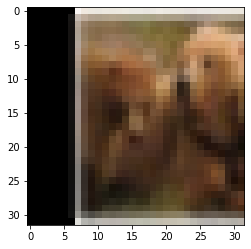

In [2]:
#test dataloader

examples = iter(train_loader)
samples, labels = examples.next()
print(samples.shape, labels.shape)

import matplotlib.pyplot as plt

img_sample = samples[0]
print(img_sample.shape)
print(img_sample.shape)
plt.imshow(img_sample.permute(1, 2, 0))
plt.show()

**Training loop**

In [3]:
#device

In [4]:
#!conda install einops
from mlp_mixer import *
from tqdm.notebook import tqdm
import numpy as np
from sklearn.metrics import accuracy_score
import json
import time

In [5]:
def get_accuracy(predicted, true_labels):
    predicted = torch.argmax(predicted.cpu(), dim=1)
    return accuracy_score(predicted, true_labels.cpu()) #forse questi passaggi a cpu non sono molto efficienti..

def generate_folder():
    import time
    import os
    import os.path
    datetime = time.strftime("%Y%m%d-%H%M%S")

    folder = f"./models/{datetime}/"
    os.chdir(".")
    print("current dir is: %s" % (os.getcwd()))

    if os.path.isdir(folder):
        print("Exists")
    else:
        os.mkdir(folder)
    return folder

#def save_model(model, path):
#    filename = path + f"{filename}.pth"
#    print(filename)
#    torch.save(model.state_dict(), filename)    

In [6]:
# credits https://github.com/facebookresearch/mixup-cifar10/blob/main/train.py 
def mixup_data(x, y, alpha=1.0):
    '''Returns mixed inputs, pairs of targets, and lambda'''
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    
    index = torch.randperm(batch_size).to(device)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam


def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)


In [7]:

experiment = Experiment(
    api_key="xX6qWBFbiOreu0W3IrO14b9nB",
    project_name="mlp-mixer",
    workspace="wedrid",
)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

image_width_height = img_sample.shape[1]
patch_dims = 4
# variable_name = value #paper value
n_channels = 32 #128 #256 #100 #512 #embed dim
loss_func = nn.CrossEntropyLoss()
learning_rate = 0.001
weight_decay = 0.1
num_layers = 4 #8
mlp_dc_dimension = 128 #512 #1024 #2048 # dc è la dimensione del channel mixing (l'ultimo mlp)
mlp_ds_dimension = 32 #64 #128 #256 # ds è la dimensione del token mixing (il primo)

mixup = False
mixup_alpha = 0.5

model = MLP_mixer(img_h_w=image_width_height, patch_dim=patch_dims, n_channels=n_channels, num_mixers_layers=num_layers,
    hidden_dim_mlp_token=mlp_ds_dimension, hidden_dim_mlp_channel=mlp_dc_dimension) #in this case 2 patches 16x16
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay=weight_decay) 

num_epochs = 300
steps_total = len(train_loader)

#ATTENZIONE: CAMBIARE IPERPARAMETRI ***PRIMAAAA*** DEL DICT SUCCESSIVO

hyper_params = {
    "dataset": root,
    "rand_augm_numops": randAugm_numops,
    "rand_augm_magnitude": randAugm_magn,
    "comment": 'added weight decay',
    "train_size": len(train_loader),
    "validation_size": len(val_loader),
    "learning_rate": learning_rate,
    "epochs": num_epochs,
    "steps": steps_total,
    "batch_size": batch_size,
    "mixup_alpha": mixup_alpha, 
    "image_width_and_height": image_width_height,
    "patch_width_and_height": patch_dims,
    "hidden_dim_size (n_channels)": n_channels,
    "number_of_layers": num_layers,
    "mlp_dc_dimension": mlp_dc_dimension,
    "mlp_ds_dimension": mlp_ds_dimension
}

experiment.log_parameters(hyper_params)
model_path = generate_folder()
with open(model_path+"/params.json", "w") as file:
    json.dump(hyper_params, file, indent=4)

model.to(device)
# training loop
for epoch in tqdm(range(num_epochs)):
    start = time.time()
    model.train()
    train_accuracy = 0
    #for i, (images, labels) in enumerate(tqdm(train_loader)):
    for i, (images, labels) in enumerate(train_loader):
        # [100, 3, 36, 36] is what is returned by iterator
        images = images.to(device)
        labels = labels.to(device)
        if not mixup: #without mixup regularization
            # forward pass
            predicted = model(images)
            loss = loss_func(predicted, labels)
            
        else:
            images, labels_a, labels_b, lam = mixup_data(images, labels, alpha=mixup_alpha)
            #images, labels_a, labels_b = map(Variable, ) no because Variable is deprecated
            predicted = model(images)
            loss = mixup_criterion(loss_func, predicted, labels_a, labels_b, lam)
            
        train_accuracy += get_accuracy(predicted, labels)
        # backwards pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if False and (i+1) % 100:
            print(f'epoch: {epoch+1} of {num_epochs}, step {i+1} of {steps_total}, loss = {loss.item():.4f}')
    print(f"Loss of epoch {epoch+1}: {loss.item():.4f}")
    train_accuracy /= len(train_loader)
    #print(f"TRAIN LOADER LENGTH: {len(train_loader)}")
    end = time.time()
    elapsed = end - start
    experiment.log_metric("train epoch loss", loss.item(), step = epoch)
    experiment.log_metric("mean train epoch accuracy", train_accuracy, step = epoch)
    experiment.log_metric("epoch time", elapsed, step = epoch)
    # validation
    with torch.no_grad():
        model.eval()
        val_accuracy = 0
        temp = 0
        for i, (images, labels) in enumerate(tqdm(val_loader)): #numero esempi/batchsize TODO check
            # [100, 3, 36, 36] is what is returned by iterator
            images = images.to(device)
            labels = labels.to(device)
            
            # forward pass
            predicted = model(images)
            loss = loss_func(predicted, labels)
            val_accuracy += get_accuracy(predicted, labels)
        #print(f"Lenght val loader: {len(val_loader)}, counter: {temp}")
        val_accuracy /= len(val_loader) 
        experiment.log_metric("val epoch loss", loss.item(), step=epoch) #TODO average loss?
        experiment.log_metric("mean val epoch accuracy", val_accuracy, step=epoch)
    
    if epoch % 10 == 0:
        torch.save(model.state_dict(), model_path + f"checkpoint_epch_{epoch}.pth")
torch.save(model.state_dict(), model_path + f"final.pth")


COMET INFO: Experiment is live on comet.ml https://www.comet.ml/wedrid/mlp-mixer/00d8e38a46314f109209855a63240535



current dir is: /Users/edrid/Desktop/Machine learning/Project/mlp_mixer


  0%|          | 0/500 [00:00<?, ?it/s]

Loss of epoch 1: 4.5775


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 2: 4.5777


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 3: 4.5520


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 4: 4.5688


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 5: 4.5777


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 6: 4.5830


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 7: 4.5834


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 8: 4.5802


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 9: 4.5760


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 10: 4.5712


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 11: 4.5722


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 12: 4.5738


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 13: 4.5803


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 14: 4.5760


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 15: 4.5666


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 16: 4.5591


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 17: 4.5741


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 18: 4.5728


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 19: 4.5623


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 20: 4.5608


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 21: 4.5695


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 22: 4.5648


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 23: 4.5683


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 24: 4.5570


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 25: 4.5738


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 26: 4.5900


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 27: 4.5813


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 28: 4.5575


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 29: 4.5703


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 30: 4.5761


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 31: 4.5581


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 32: 4.5676


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 33: 4.5690


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 34: 4.5554


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 35: 4.5684


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 36: 4.5507


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 37: 4.5647


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 38: 4.5648


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 39: 4.5703


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 40: 4.5574


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 41: 4.5595


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 42: 4.5810


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 43: 4.5588


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 44: 4.5652


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 45: 4.5635


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 46: 4.5645


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 47: 4.5717


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 48: 4.5710


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 49: 4.5613


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 50: 4.5652


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 51: 4.5647


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 52: 4.5612


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 53: 4.5499


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 54: 4.5523


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 55: 4.5558


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 56: 4.5777


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 57: 4.5616


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 58: 4.5594


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 59: 4.5704


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 60: 4.5753


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 61: 4.5669


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 62: 4.5605


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 63: 4.5685


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 64: 4.5736


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 65: 4.5703


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 66: 4.5652


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 67: 4.5697


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 68: 4.5558


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 69: 4.5720


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 70: 4.5700


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 71: 4.5633


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 72: 4.5619


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 73: 4.5643


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 74: 4.5536


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 75: 4.5644


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 76: 4.5553


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 77: 4.5656


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 78: 4.5663


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 79: 4.5525


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 80: 4.5751


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 81: 4.5645


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 82: 4.5749


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 83: 4.5633


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 84: 4.5744


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 85: 4.5768


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 86: 4.5413


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 87: 4.5630


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 88: 4.5646


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 89: 4.5592


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 90: 4.5679


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 91: 4.5801


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 92: 4.5781


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 93: 4.5603


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 94: 4.5600


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 95: 4.5614


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 96: 4.5778


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 97: 4.5904


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 98: 4.5573


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 99: 4.5660


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 100: 4.5601


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 101: 4.5633


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 102: 4.5596


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 103: 4.5729


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 104: 4.5806


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 105: 4.5739


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 106: 4.5658


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 107: 4.5786


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 108: 4.5569


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 109: 4.5632


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 110: 4.5636


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 111: 4.5633


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 112: 4.5702


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 113: 4.5699


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 114: 4.5692


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 115: 4.5678


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 116: 4.5602


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 117: 4.5722


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 118: 4.5673


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 119: 4.5699


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 120: 4.5528


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 121: 4.5717


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 122: 4.5541


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 123: 4.5664


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 124: 4.5712


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 125: 4.5786


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 126: 4.5722


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 127: 4.5624


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 128: 4.5639


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 129: 4.5586


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 130: 4.5631


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 131: 4.5803


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 132: 4.5576


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 133: 4.5606


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 134: 4.5614


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 135: 4.5607


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 136: 4.5743


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 137: 4.5632


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 138: 4.5579


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 139: 4.5620


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 140: 4.5622


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 141: 4.5730


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 142: 4.5684


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 143: 4.5676


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 144: 4.5785


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 145: 4.5828


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 146: 4.5716


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 147: 4.5412


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 148: 4.5773


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 149: 4.5727


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 150: 4.5675


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 151: 4.5587


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 152: 4.5751


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 153: 4.5704


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 154: 4.5565


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 155: 4.5602


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 156: 4.5749


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 157: 4.5699


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 158: 4.5549


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 159: 4.5605


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 160: 4.5813


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 161: 4.5608


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 162: 4.5814


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 163: 4.5788


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 164: 4.5613


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 165: 4.5533


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 166: 4.5755


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 167: 4.5722


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 168: 4.5656


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 169: 4.5707


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 170: 4.5707


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 171: 4.5784


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 172: 4.5689


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 173: 4.5643


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 174: 4.5682


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 175: 4.5660


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 176: 4.5678


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 177: 4.5761


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 178: 4.5741


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 179: 4.5819


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 180: 4.5496


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 181: 4.5620


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 182: 4.5728


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 183: 4.5716


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 184: 4.5748


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 185: 4.5741


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 186: 4.5582


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 187: 4.5521


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 188: 4.5797


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 189: 4.5595


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 190: 4.5721


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 191: 4.5628


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 192: 4.5682


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 193: 4.5613


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 194: 4.5625


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 195: 4.5627


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 196: 4.5441


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 197: 4.5695


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 198: 4.5781


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 199: 4.5753


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 200: 4.5743


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 201: 4.5795


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 202: 4.5749


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 203: 4.5559


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 204: 4.5646


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 205: 4.5624


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 206: 4.5574


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 207: 4.5552


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 208: 4.5686


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 209: 4.5558


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 210: 4.5762


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 211: 4.5804


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 212: 4.5744


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 213: 4.5662


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 214: 4.5713


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 215: 4.5764


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 216: 4.5550


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 217: 4.5818


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 218: 4.5547


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 219: 4.5532


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 220: 4.5600


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 221: 4.5767


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 222: 4.5782


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 223: 4.5598


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 224: 4.5716


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 225: 4.5569


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 226: 4.5766


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 227: 4.5733


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 228: 4.5843


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 229: 4.5734


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 230: 4.5652


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 231: 4.5397


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 232: 4.5618


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 233: 4.5648


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 234: 4.5633


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 235: 4.5602


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 236: 4.5453


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 237: 4.5680


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 238: 4.5564


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 239: 4.5471


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 240: 4.5483


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 241: 4.5837


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 242: 4.5682


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 243: 4.5637


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 244: 4.5784


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 245: 4.5937


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 246: 4.5831


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 247: 4.5577


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 248: 4.5587


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 249: 4.5732


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 250: 4.5599


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 251: 4.5714


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 252: 4.5750


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 253: 4.5647


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 254: 4.5644


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 255: 4.5616


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 256: 4.5645


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 257: 4.5575


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 258: 4.5641


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 259: 4.5623


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 260: 4.5612


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 261: 4.5777


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 262: 4.5634


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 263: 4.5818


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 264: 4.5663


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 265: 4.5584


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 266: 4.5657


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 267: 4.5805


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 268: 4.5758


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 269: 4.5684


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 270: 4.5596


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 271: 4.5734


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 272: 4.5552


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 273: 4.5911


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 274: 4.5663


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 275: 4.5697


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 276: 4.5695


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 277: 4.5405


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 278: 4.5512


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 279: 4.5585


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 280: 4.5742


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 281: 4.5640


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 282: 4.5581


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 283: 4.5597


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 284: 4.5637


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 285: 4.5552


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 286: 4.5438


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 287: 4.5369


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 288: 4.5727


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 289: 4.5583


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 290: 4.5592


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 291: 4.5680


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 292: 4.5712


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 293: 4.5574


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 294: 4.5677


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 295: 4.5753


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 296: 4.5511


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 297: 4.5830


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 298: 4.5697


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 299: 4.5692


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 300: 4.5598


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 301: 4.5597


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 302: 4.5542


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 303: 4.5543


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 304: 4.5724


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 305: 4.5700


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 306: 4.5674


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 307: 4.5922


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 308: 4.5779


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 309: 4.5500


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 310: 4.5766


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 311: 4.5790


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 312: 4.5744


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 313: 4.5687


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 314: 4.5621


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 315: 4.5629


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 316: 4.5844


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 317: 4.5673


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 318: 4.5577


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 319: 4.5775


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 320: 4.5682


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 321: 4.5689


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 322: 4.5790


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 323: 4.5664


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 324: 4.5617


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 325: 4.5729


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 326: 4.5643


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 327: 4.5673


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 328: 4.5660


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 329: 4.5652


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 330: 4.5706


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 331: 4.5812


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 332: 4.5756


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 333: 4.5612


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 334: 4.5721


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 335: 4.5739


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 336: 4.5718


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 337: 4.5670


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 338: 4.5751


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 339: 4.5693


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 340: 4.5805


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 341: 4.5496


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 342: 4.5761


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 343: 4.5601


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 344: 4.5596


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 345: 4.5758


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 346: 4.5633


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 347: 4.5608


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 348: 4.5675


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 349: 4.5613


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 350: 4.5612


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 351: 4.5571


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 352: 4.5478


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 353: 4.5740


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 354: 4.5817


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 355: 4.5726


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 356: 4.5670


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 357: 4.5543


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 358: 4.5725


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 359: 4.5577


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 360: 4.5650


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 361: 4.5785


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 362: 4.5574


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 363: 4.5659


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 364: 4.5627


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 365: 4.5577


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 366: 4.5731


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 367: 4.5733


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 368: 4.5667


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 369: 4.5728


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 370: 4.5720


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 371: 4.5757


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 372: 4.5578


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 373: 4.5719


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 374: 4.5521


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 375: 4.5549


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 376: 4.5641


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 377: 4.5668


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 378: 4.5746


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 379: 4.5764


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 380: 4.5623


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 381: 4.5474


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 382: 4.5681


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 383: 4.5611


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 384: 4.5763


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 385: 4.5628


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 386: 4.5775


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 387: 4.5697


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 388: 4.5597


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 389: 4.5538


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 390: 4.5748


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 391: 4.5790


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 392: 4.5538


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 393: 4.5917


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 394: 4.5549


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 395: 4.5701


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 396: 4.5576


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 397: 4.5721


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 398: 4.5731


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 399: 4.5694


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 400: 4.5642


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 401: 4.5799


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 402: 4.5528


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 403: 4.5702


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 404: 4.5702


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 405: 4.5739


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 406: 4.5759


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 407: 4.5748


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 408: 4.5576


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 409: 4.5616


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 410: 4.5748


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 411: 4.5643


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 412: 4.5508


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 413: 4.5805


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 414: 4.5672


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 415: 4.5741


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 416: 4.5573


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 417: 4.5671


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 418: 4.5772


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 419: 4.5748


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 420: 4.5639


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 421: 4.5653


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 422: 4.5673


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 423: 4.5815


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 424: 4.5671


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 425: 4.5689


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 426: 4.5797


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 427: 4.5902


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 428: 4.5684


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 429: 4.5788


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 430: 4.5740


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 431: 4.5728


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 432: 4.5685


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 433: 4.5643


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 434: 4.5755


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 435: 4.5554


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 436: 4.5661


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 437: 4.5650


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 438: 4.5540


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 439: 4.5553


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 440: 4.5648


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 441: 4.5706


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 442: 4.5726


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 443: 4.5488


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 444: 4.5584


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 445: 4.5704


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 446: 4.5523


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 447: 4.5517


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 448: 4.5707


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 449: 4.5476


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 450: 4.5604


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 451: 4.5785


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 452: 4.5723


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 453: 4.5750


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 454: 4.5713


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 455: 4.5543


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 456: 4.5725


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 457: 4.5674


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 458: 4.5633


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 459: 4.5748


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 460: 4.5697


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 461: 4.5638


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 462: 4.5658


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 463: 4.5618


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 464: 4.5726


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 465: 4.5664


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 466: 4.5635


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 467: 4.5815


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 468: 4.5669


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 469: 4.5664


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 470: 4.5522


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 471: 4.5715


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 472: 4.5859


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 473: 4.5638


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 474: 4.5780


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 475: 4.5709


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 476: 4.5773


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 477: 4.5536


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 478: 4.5522


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 479: 4.5486


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 480: 4.5654


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 481: 4.5539


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 482: 4.5602


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 483: 4.5761


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 484: 4.5617


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 485: 4.5652


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 486: 4.5638


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 487: 4.5629


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 488: 4.5651


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 489: 4.5656


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 490: 4.5656


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 491: 4.5548


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 492: 4.5708


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 493: 4.5658


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 494: 4.5472


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 495: 4.5607


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 496: 4.5629


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 497: 4.5764


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 498: 4.5712


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 499: 4.5781


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 500: 4.5561


  0%|          | 0/60 [00:00<?, ?it/s]

In [8]:
if False: 
    examples = iter(train_loader)
    images, labels = examples.next()

    # metrics trial
    images = images.to(device)
    labels = labels.to(device)

    # forward pass
    outputs = model(images)
    loss = loss_func(outputs, labels)

    #da mettere nel ciclo
    print(outputs.shape)

    #####
    predicted = torch.argmax(outputs, dim=1)
    accuracy = accuracy_score(predicted, labels)
    print(f'Accuracy {accuracy}')
    #####
    print(predicted.shape)
    print(predicted)
